# pyTorch Convolutional Neural Networks (CNNs)

<div style="padding: 5px; border: 5px solid #a10000ff;">

**Hinweis:** In den Codezellen sind jeweils einige Codeteile nicht programmiert. Diesen Code müssen Sie ergänzen. Die jeweiligen Stellen sind mit einem Kommentar und dem Keyword **TODO** vermerkt und z.T. Stellen mit ... markiert.

Ausserdem gibt es einige assert Statements. Diese geben einen Fehler aus, sollte etwas bei Ihrer Programmierung nicht korrekt sein.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader
import os
import random
import PIL.Image as Image

### Torch vorbereiten

In [12]:
# Wir prüfen ob eine Hardwarebeschleunigung möglich ist und verwenden diese, wenn sie verfügbar ist
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
torch.manual_seed(42) # Setze den Zufallsseed für Reproduzierbarkeit
print(f"Using {device} device")

Using cpu device


## Aufgabe 1: Modelle laden
In diesem Notebook laden wir die drei vortrainierten Modelle aus dem Notebook *07_pytorch_convolution_FER.ipynb* um diese noch genauer auf ihre Performance zu untersuchen.

1. Wir müssen die Architektur der zwei eigenen Modelle definieren, damit wir die Gewichte laden können. Kopieren Sie die dazu die Definitionen der drei Modelle aus dem letzten Notebook hierher. Der Code ist bereits vorbereitet und gekennzeichnet.
2. Wir laden die drei Modelle mit den entsprechenden Gewichten, die Sie im letzten Notebook gespeichert haben. Der Code ist vorbereitet.

### Architektur-Definition Modell 1

In [13]:
model_1 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=12, kernel_size=7, stride=1, padding=0),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5, stride=1, padding=0),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=16*8*8, out_features=7),
)

### Architektur-Definition Modell 2

In [14]:
model_2 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=2),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=32*12*12, out_features=128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(in_features=128, out_features=7),
)

### Architektur-Definition Modell 3

In [15]:
model_3 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
    torch.nn.Sigmoid(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    torch.nn.Sigmoid(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=32*12*12, out_features=7),
)

### Laden der Modell-Gewichte


In [16]:
#TODO Passen Sie je die Pfade und die Dateinamen an, so dass die Gewichte der drei Modelle korrekt geladen werden
model_1.load_state_dict(torch.load("FER_cnn.pth"))
model_2.load_state_dict(torch.load("FER_cnn_model_2.pth"))
model_3.load_state_dict(torch.load("FER_cnn_model_3.pth"))

<All keys matched successfully>

## FER-2013 Dataset für Testing laden

Zur Erinnerung: Das FER-2013 Dataset enthält Bilder von Gesichtern, die in verschiedene Emotionen klassifiziert sind. Es ist ein häufig verwendetes Dataset für die Gesichtsemotionserkennung. 
In diesem Abschnitt werden wir das Dataset vorbereiten, laden und einige Beispiele visualisieren.

Ausserdem prüfen wir wie im letzten Notebook die Daten auf mögliche Probleme.

*Datasetquelle: https://www.kaggle.com/datasets/msambare/fer2013*

### Daten laden

In [17]:
data_path = "datasets/FER-2013/"
data_test_path = os.path.join(data_path, "test")

In [18]:
test_images = torch.load(os.path.join(data_test_path, "test_images.pt"))
test_labels = torch.load(os.path.join(data_test_path, "test_labels.pt"))


label_mapping = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'sad': 4,
    'surprise': 5,
    'neutral': 6
}

reverse_label_mapping = {v: k for k, v in label_mapping.items()}


### Beispielbilder aus dem FER-2013 Dataset visualisieren

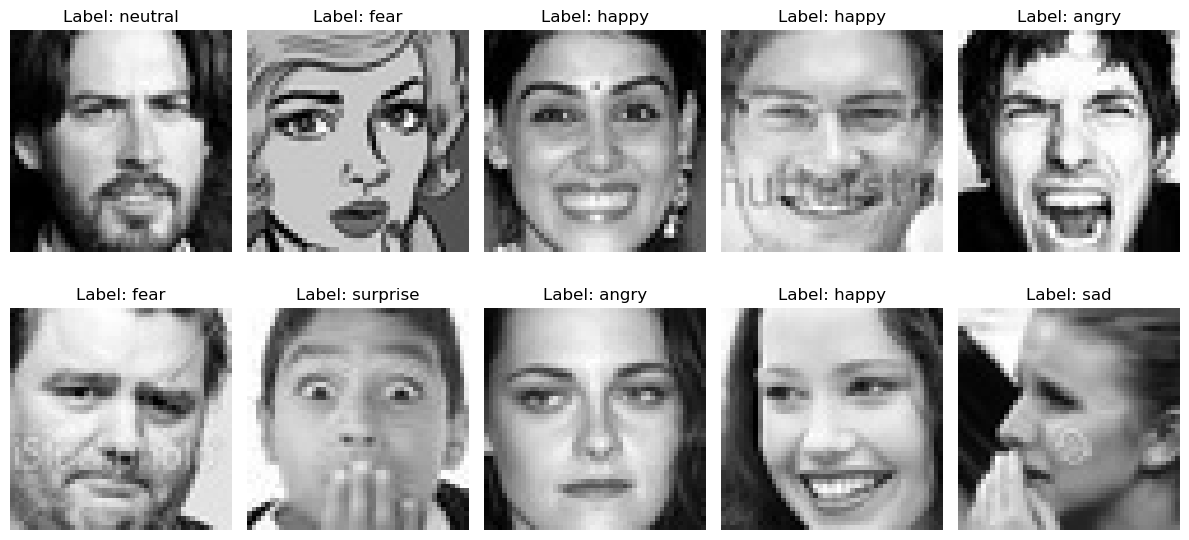

In [19]:
# 10 Beispiele plotten
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    random_index = random.randint(0, len(test_images) - 1)
    ax = axes[i // 5, i % 5]
    ax.imshow(test_images[random_index].squeeze(), cmap='gray')
    ax.set_title(f"Label: {reverse_label_mapping[test_labels[random_index].item()]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


### Vorhersagen auf den Testdaten mit allen drei Modellen machen

Wir werden die Vorhersagen der drei Modelle auf den Testdaten machen. Diese vergleichen wir dann mit den tatsächlichen Labels, um im nächsten Abschnitt die Performance der Modelle zu evaluieren.
Da wir die Trainingsdaten normalisiert haben, werden wir auch die Testdaten normalisieren, bevor wir die Vorhersagen machen.

In [21]:
# Testdaten normalisieren
test_images_tensors = test_images.float() / 255.0

model_1_predictions = model_1(test_images_tensors)
model_2_predictions = model_2(test_images_tensors)
model_3_predictions = model_3(test_images_tensors)

## Auswertungen der Modelle

Bis anhin haben wir die Modelle nur anhand der Accuracy ausgewertet.
In diesem Abschnitt werden wir weitere Metriken berechnen, um die Performance der Modelle genauer zu untersuchen. Dazu gehören die **Precision**, **Recall** und **F1-Score**. Ausserdem werden wir die **Confusion-Matrix** berechnen und visualisieren, um zu sehen, welche Klassen von den Modellen am häufigsten verwechselt werden.

Wir werden diese Metriken als einzeln behandeln und dann in einem Vergleich zusammenfassen. Um diese Metriken zu berechnen müssen wir noch die Begriffe **True Positives (TP)**, **False Positives (FP)**, **True Negatives (TN)** und **False Negatives (FN)** definieren. Diese Begriffe beziehen sich auf die Anzahl der korrekt und falsch klassifizierten Datenpunkte für jede Klasse.

### True Positives, False Positives, True Negatives und False Negatives

- **True Positives (TP)**: Anzahl der Datenpunkte, die korrekt als eine bestimmte Klasse klassifiziert wurden.
- **False Positives (FP)**: Anzahl der Datenpunkte, die fälschlicherweise als eine bestimmte Klasse klassifiziert wurden.
- **True Negatives (TN)**: Anzahl der Datenpunkte, die korrekt als nicht zu einer bestimmten Klasse gehörend klassifiziert wurden.
- **False Negatives (FN)**: Anzahl der Datenpunkte, die fälschlicherweise als nicht zu einer bestimmten Klasse gehörend klassifiziert wurden.

Da wir die TP, FP, TN und FN für die verschiedenen Metriken benötigen, werden wir diese zuerst einzeln pro Modell und Klasse berechnen.
Wir erstellen ein Pandasp DataFrame, um diese Werte für jedes Modell und jede Klasse zu speichern. Dies erleichtert die Berechnung der Metriken im nächsten Schritt.

In [ ]:
model_1_metrics = pd.DataFrame(columns=["Class", "TP", "FP", "TN", "FN"])
model_2_metrics = pd.DataFrame(columns=["Class", "TP", "FP", "TN", "FN"])
model_3_metrics = pd.DataFrame(columns=["Class", "TP", "FP", "TN", "FN"])

### Precision

Unser Modell kann mehrere Klassen vorhersagen, daher müssen wir die Precision für jede Klasse separat berechnen. Die Precision für eine Klasse ist definiert als:
$Precision = \frac{TP}{TP + FP}$

Die Precision sagt uns, wie viele der Datenpunkte, die als eine bestimmte Klasse klassifiziert wurden, tatsächlich zu dieser Klasse gehören. Eine hohe Precision bedeutet, dass unser Modell wenige False Positives für eine Klasse hat.

